# Soluciones a la ecuación de Mathieu

La ecuación de Mathieu es de la forma 

$$\displaystyle \frac{d^2 \chi_k}{dT^2} + \left[ A_k - 2q \cos(2T) \right] \chi_k = 0 \tag{1}$$

dónde $A_k$ y $q$ son los parámetros de la resonancia paramétrica y van a estar dados por

$$q = \frac{g^2}{4} \left( \frac{\phi_0}{m} \right)^2; \hspace{3cm} A_k = \left( \frac{k}{m} \right)^2 + 2 q; \hspace{3cm} T = m t + \frac{\pi}{2} \tag{2}$$

dónde $g$ es la constante de acoplamiento entre el campo del inflatón $\phi$ y el campo hijo $\chi$, $m$ es la masa del campo hijo, $\phi_0$ es el valor inicial del campo inflatón y $k$ es el valor del número de onda del modo que queremos ver cómo evoluciona para el campo hijo.

El campo del inflatón planteamos que es de la forma 

$$\phi (t) = \phi_0 \cos (mt) \tag{3}$$

que sale de resolver la ecuación 

$$\ddot{\phi} + \frac{\partial V}{\partial \phi} = 0 \tag{4}$$

para un potencial armónico de la forma

$$V(\phi) = \frac{1}{2} m^2 \phi^2 \tag{5}$$

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp
import sympy as sp

mpl.rc('figure', figsize=(12, 6))
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)

## Funciones

A partir de la ecuación (1) podemos definir una función de primer orden que pueda resolver numéricamente la ecuación de Mathieu, para hacer ésto podemos definir $u = \chi_k$ y $\displaystyle v = \frac{d \chi}{dT}$ podemos escribir la ecuación de Mathieu como el siguiente sistema de ecuaciones:

$$\begin{cases}
    u^\prime &= v\\
    v^\prime &= - \left[ A_k - 2q \cos(2T) \right] \chi_k
\end{cases} \tag{6}$$

dónde el primado es la derivada respecto $T$.

La ecuación de Mathieu (1) tiene por solución algo de la forma

$$\chi_k = \mathcal{M}^{(+)}_k (T) ~ e^{\mu_k T} + \mathcal{M}^{(-)}_k (T) ~ e^{- \mu_k T} \tag{7}$$

siendo $\mu_k$ los coeficientes de Floquet. Para calcular estos coeficientes, se puede seguir un algoritmo como el que describe [arXiv:1410.3808] en la sección 3, la idea general es obtener la matriz 

$$\mathcal{O}(t_0 + T, t_0) = \begin{pmatrix}
    u^{(1)} (t_0 + T) & u^{(2)} (t_0 + T)\\
    v^{(1)} (t_0 + T) & v^{(2)} (t_0 + T)\\
\end{pmatrix} \tag{8}$$

dónde el supraíndice $(1),(2)$ indica cuando consideramos como condiciones iniciales (1,0) y (0,1) para $u$ y $v$. Entonces, este coeficiente lo podemos calcular como

$$\mu = \frac{1}{T} \cosh^{-1} \left[ \frac{\text{Tr} \left( \mathcal{O} \right)}{2} \right] \tag{9}$$

notemos que si la traza es menor que 2 tendremos un valor real para $\mu$ mientras que si la traza es mayor que 2 tendremos un valor imaginario para $\mu$.

In [2]:
# Ecuación de Mathieu
def mathieu(t, y, A_k, q):
    u, v = y
    du_dt = v
    dv_dt = - (A_k - 2 * q * np.cos(2 * t)) * u
    return [du_dt, dv_dt]

# Coeficientes de Floquet
def floquet_coeff(A, q):
    T = np.pi                                                                       # Periodo de la función coseno (recordar que tenemos cos(2T))
    sol1 = solve_ivp(mathieu, [0, T], [1, 0], args=(A, q), rtol=1e-8, atol=1e-8)
    y1, y1_prime = sol1.y[0][-1], sol1.y[1][-1]

    sol2 = solve_ivp(mathieu, [0, T], [0, 1], args=(A, q), rtol=1e-8, atol=1e-8)
    y2, y2_prime = sol2.y[0][-1], sol2.y[1][-1]

    M = np.array([[y1, y2], [y1_prime, y2_prime]])
    Delta = np.trace(M)

    if abs(Delta) > 2:
        mu_real = np.arccosh(abs(Delta)/2) / T
        mu_imag = 0
    else:
        mu_real = 0
        mu_imag = np.arccos(Delta/2) / T
    mu = mu_real + 1j * mu_imag
    return mu

# Guardar los resultados en una matriz con Ak en las filas, q en las columnas y mu en las celdas
def save_csv(Aks, qs, mu, filename='results'):
    # Parte real
    output_real = np.zeros((len(Aks)+1, len(qs)+1))
    output_real[0, 1:] = qs
    output_real[1:, 0] = Aks
    output_real[1:, 1:] = np.real(mu)
    np.savetxt(f"{filename}_real.csv", output_real, delimiter=",")
    
    # Parte imaginaria
    output_imag = np.zeros((len(Aks)+1, len(qs)+1))
    output_imag[0, 1:] = qs
    output_imag[1:, 0] = Aks
    output_imag[1:, 1:] = np.imag(mu)
    np.savetxt(f"{filename}_imag.csv", output_imag, delimiter=",")

## Tabla de inestabilidades de Mathieu

Primero tomemos $A_k \in (0, 15)$ y $q \in (0,5)$ para replicar la figura 20 de $\textit{Cosmic Inflation: Background dynamics, Quantum fluctuations and}$ $\textit{Reheating}$ de Swagat S. Mishra.

In [3]:
qs = np.linspace(0, 5, 200)
Aks = np.linspace(0, 15, 200)
q, Ak = np.meshgrid(qs, Aks)
mu = np.zeros((len(Aks), len(qs)), dtype=complex)

for i in range(len(Aks)):
    for j in range(len(qs)):
        mu[i, j] = floquet_coeff(Aks[i], qs[j])

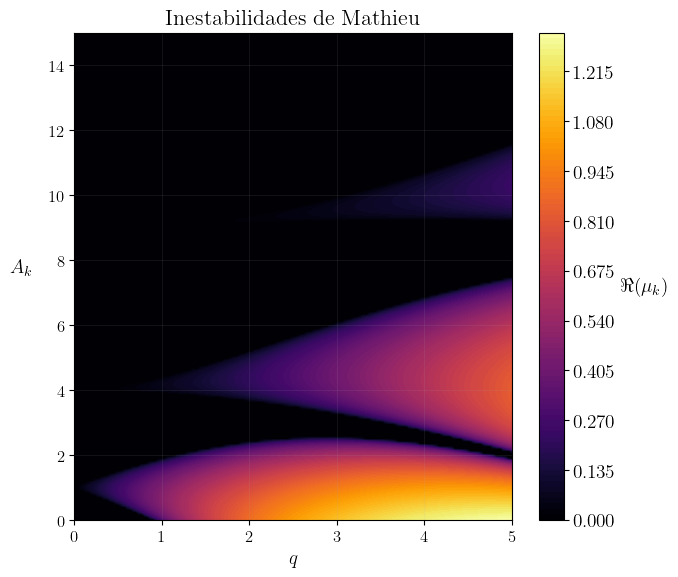

In [4]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(q, Ak, np.real(mu), levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Re(\mu_k)$', fontsize=14, labelpad=20, rotation=0)

plt.title(r'Inestabilidades de Mathieu', fontsize=16)
plt.xlabel(r'$q$', fontsize=14)
plt.ylabel(r'$A_k$', fontsize=14, labelpad=20, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [5]:
# Guardemos los resultados en un archivo CSV
save_csv(Aks, qs, mu, filename='mathieu_results1')

Ahora extendamos este gráfico a $A_k \in (0, 100)$ y $q \in (0,200)$ para ver cómo son las bandas en valores más grandes de $q$ y $A_k$

In [6]:
qs = np.linspace(0, 200, 200)
Aks = np.linspace(0, 100, 200)
q, Ak = np.meshgrid(qs, Aks)
mu = np.zeros((len(Aks), len(qs)), dtype=complex)

for i in range(len(Aks)):
    for j in range(len(qs)):
        mu[i, j] = floquet_coeff(Aks[i], qs[j])

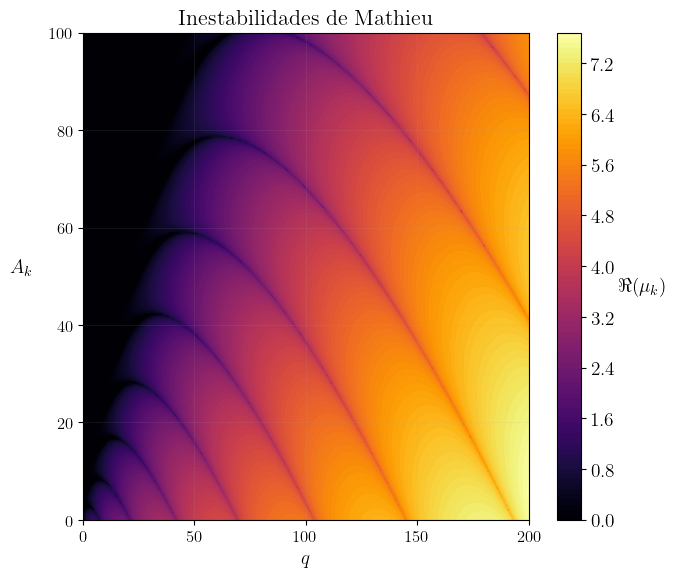

In [7]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(q, Ak, np.real(mu), levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Re(\mu_k)$', fontsize=14, labelpad=20, rotation=0)

plt.title(r'Inestabilidades de Mathieu', fontsize=16)
plt.xlabel(r'$q$', fontsize=14)
plt.ylabel(r'$A_k$', fontsize=14, labelpad=20, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [8]:
# Guardemos los resultados en un archivo CSV
save_csv(Aks, qs, mu, filename='mathieu_results2')

## Tipos de resonancias

### $q$ chicos (Narrow resonance)

La ecuación (2) nos decía

$$q = \frac{g^2}{4} \left( \frac{\phi_0}{m} \right)^2; \hspace{3cm} A_k = \left( \frac{k}{m} \right)^2 + 2 q; \hspace{3cm} T = m t + \frac{\pi}{2}$$

entonces, veamos para valores fijos de $q$ cómo es la resonancia para distintos modos.

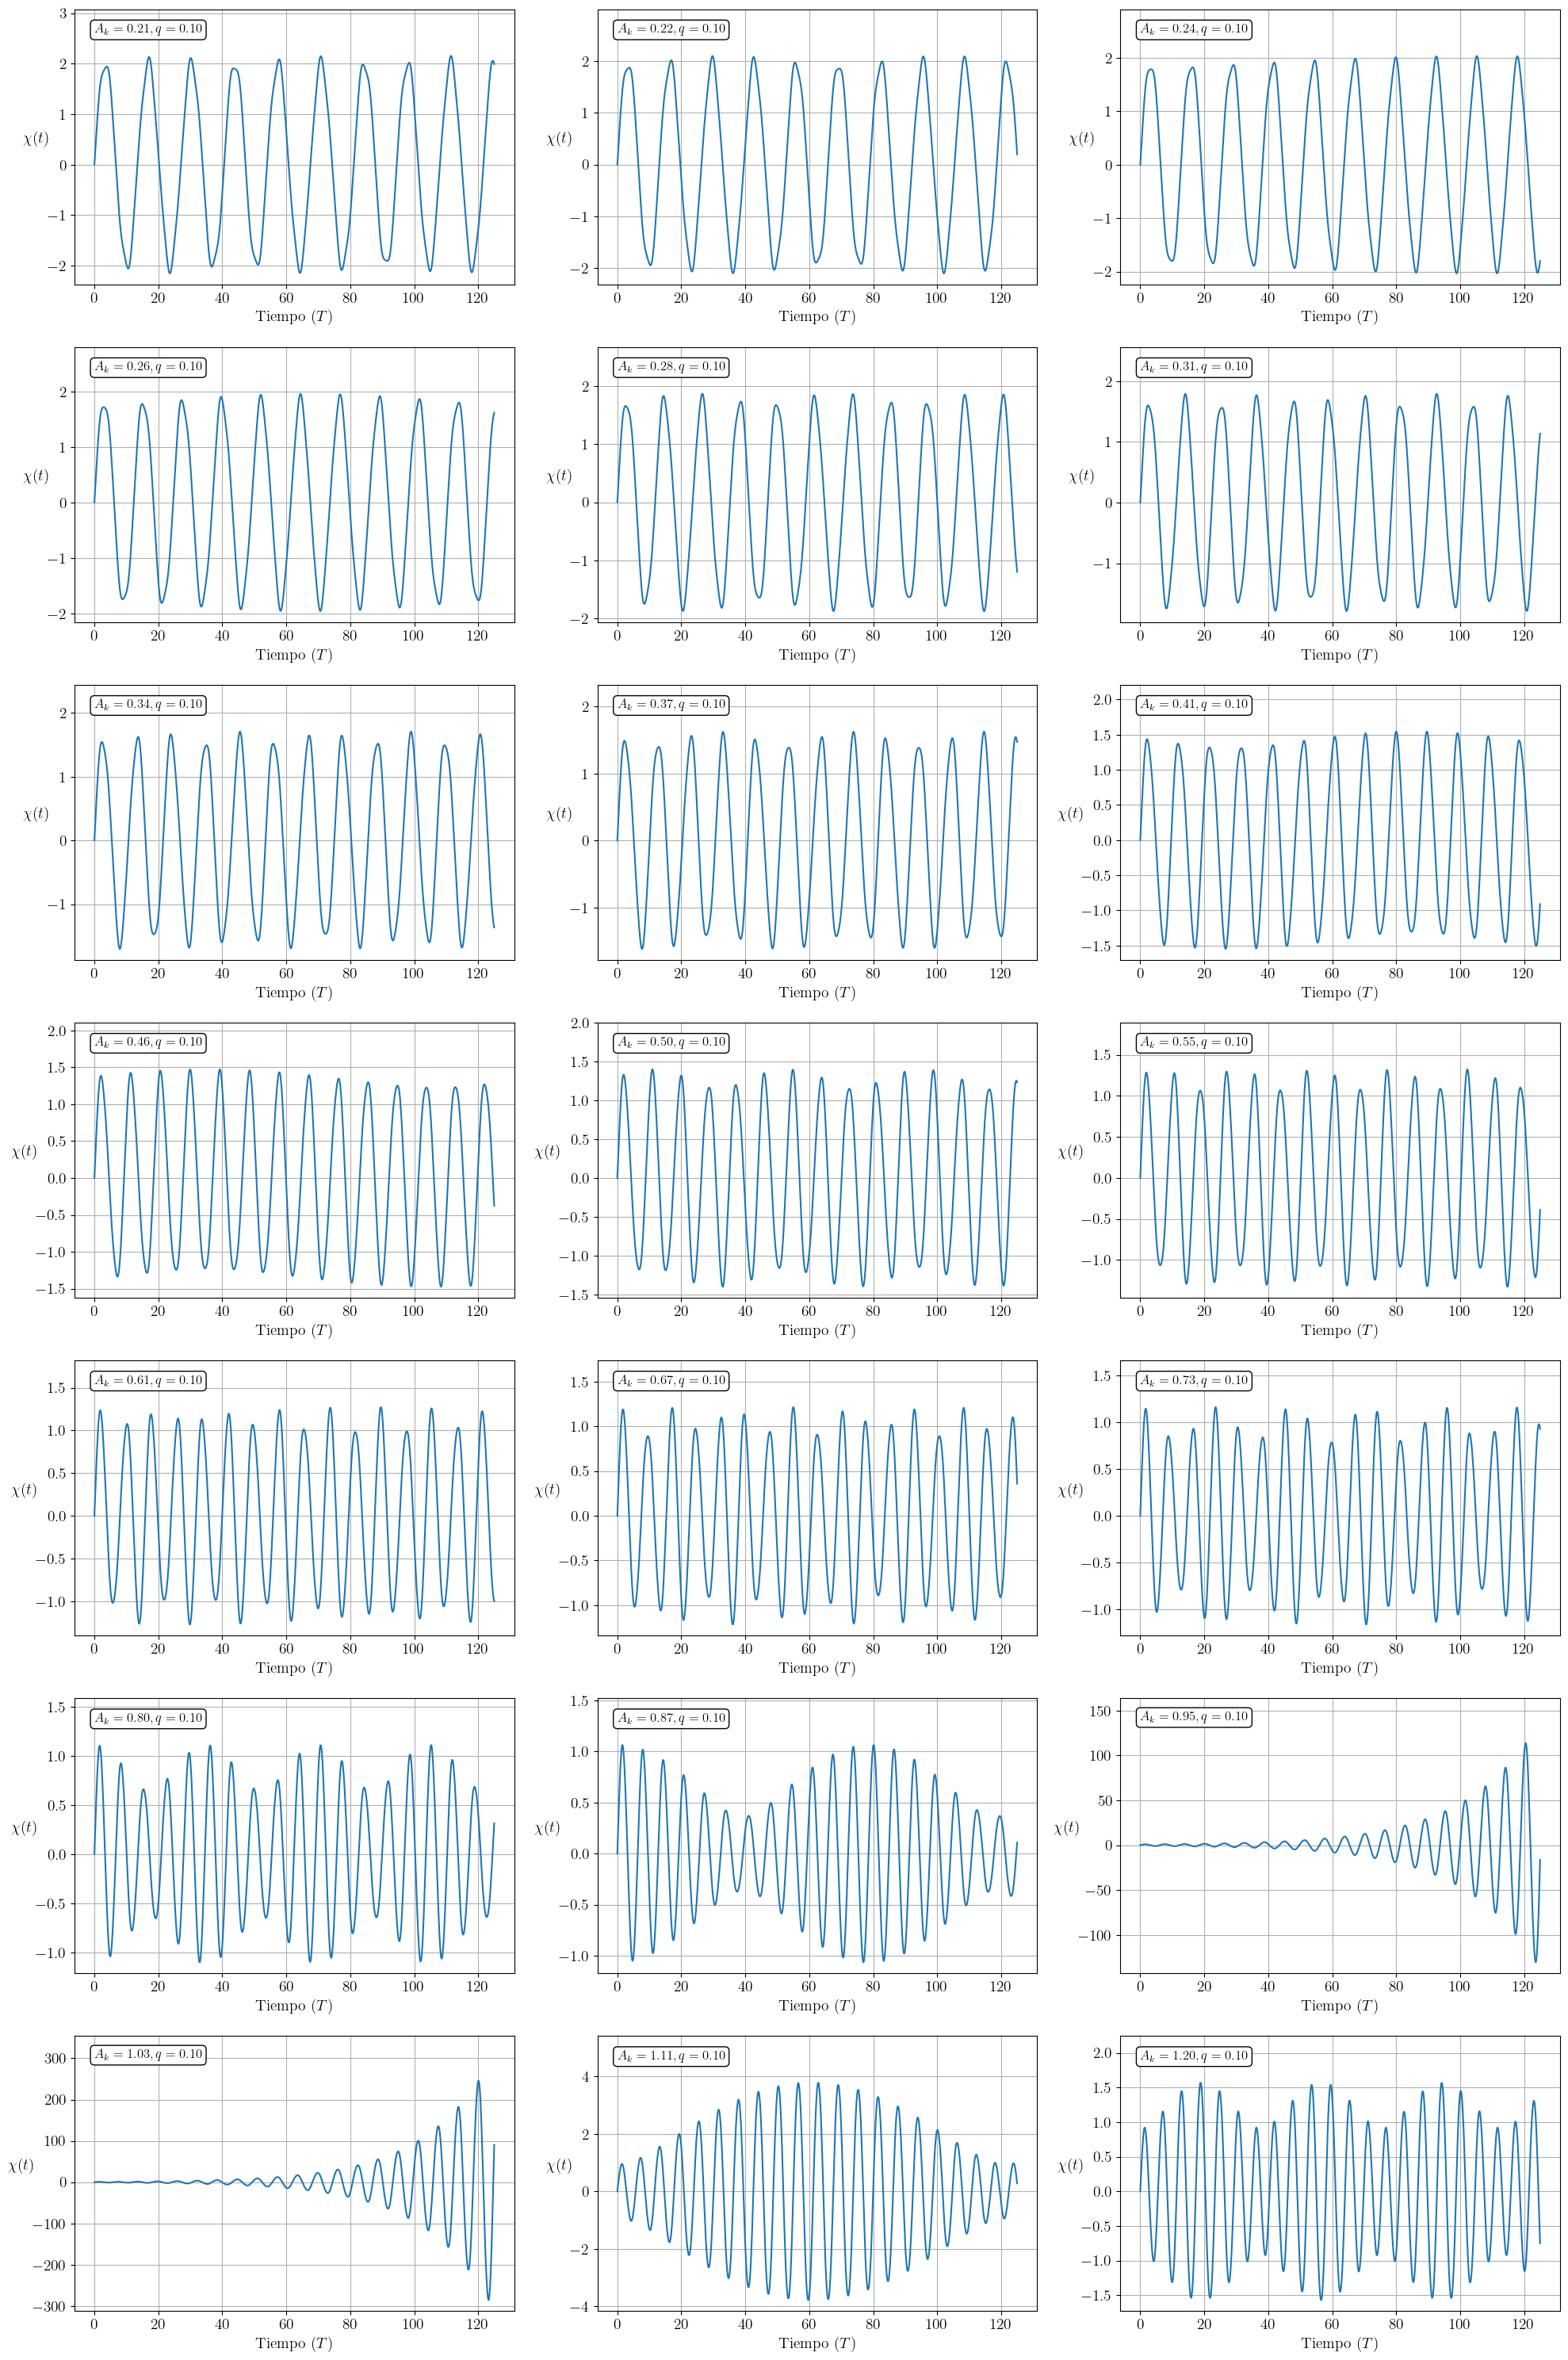

In [9]:
km = np.linspace(1e-1, 1, 21)                           # Valores de k/m (modos)
u0, v0 = 0, 1                                           # Condiciones iniciales
T0, Tf = 0, 125                                         # Tiempos
q = 0.1                             

plt.figure(figsize=(20, 30))

for k in range(len(km)):
    Ak = km[k]**2 + 2 * q
    sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
    T, y, y_prime = sol.t, sol.y[0], sol.y[1]

    # Graficamos los resultados
    plt.subplot(7, 3, k + 1)
    plt.plot(T, y)
    plt.xlabel(r'Tiempo ($T$)')
    plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim(ymin, ymax*1.3)
    plt.text(x=T[0], y=ymax*1.1, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.grid()

plt.tight_layout()
plt.show()

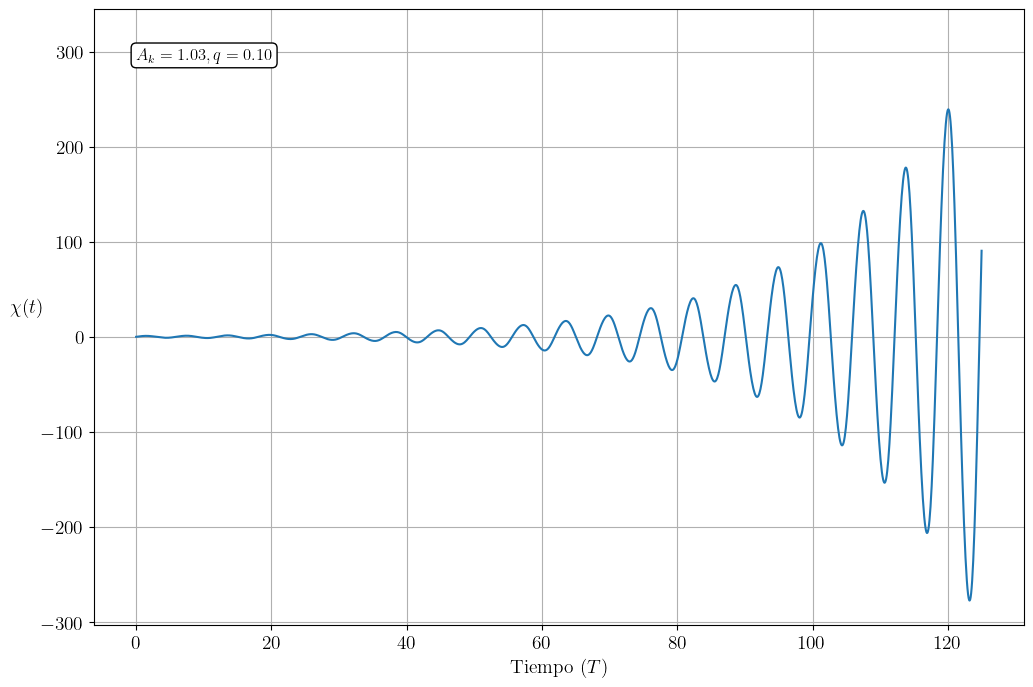

In [10]:
# Centrémosnos sólo en el que tiene A_k = 1.03 y q = 0.1
u0, v0 = 0, 1                                           # Condiciones iniciales
T0, Tf = 0, 125                                         # Tiempos
q = 0.1                             
Ak = 1.03

sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
T, y, y_prime = sol.t, sol.y[0], sol.y[1]

# Graficamos los resultados
plt.figure(figsize=(12, 8))
plt.plot(T, y)
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax*1.3)
plt.text(x=T[0], y=ymax*1.1, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()
plt.show()

### $q$ grande (Broad resonance)

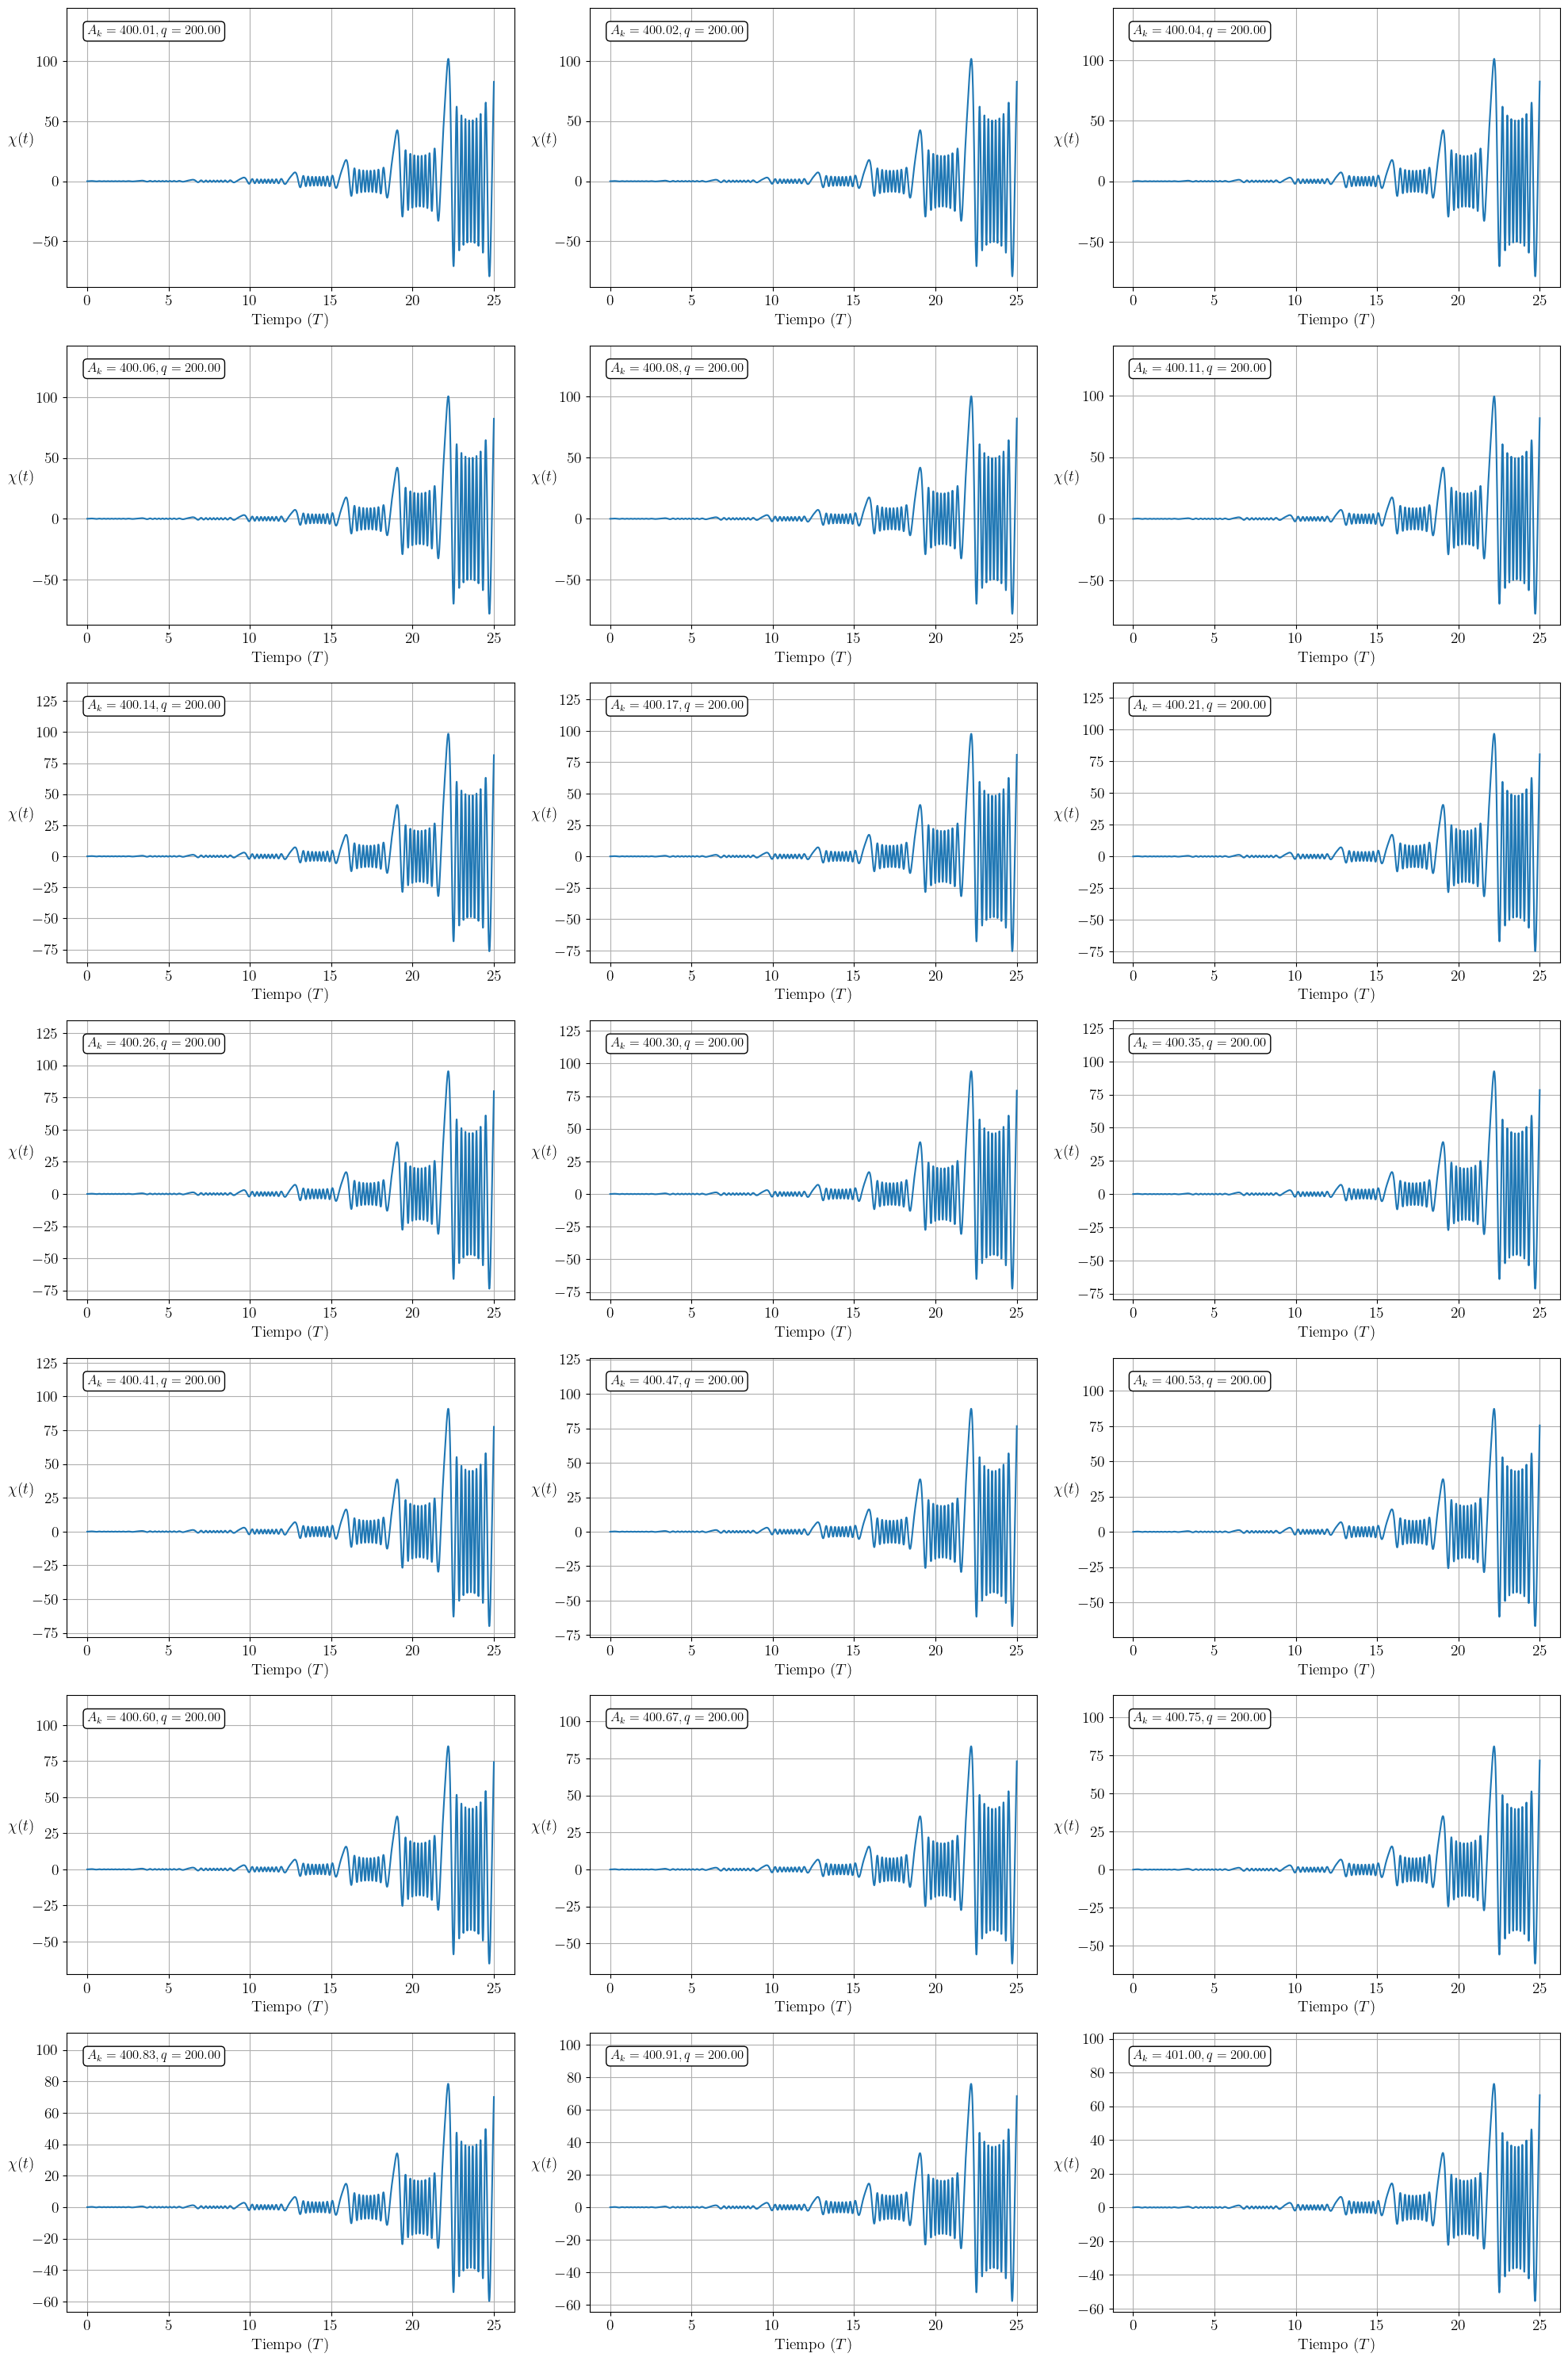

In [11]:
km = np.linspace(1e-1, 1, 21)                           # Valores de k/m (modos)
u0, v0 = 0, 1                                           # Condiciones iniciales
T0, Tf = 0, 25                                          # Tiempos
q = 200                             

plt.figure(figsize=(20, 30))

for k in range(len(km)):
    Ak = km[k]**2 + 2 * q
    sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
    T, y, y_prime = sol.t, sol.y[0], sol.y[1]

    # Graficamos los resultados
    plt.subplot(7, 3, k + 1)
    plt.plot(T, y)
    plt.xlabel(r'Tiempo ($T$)')
    plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim(ymin, ymax*1.3)
    plt.text(x=T[0], y=ymax*1.1, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.grid()

plt.tight_layout()
plt.show()

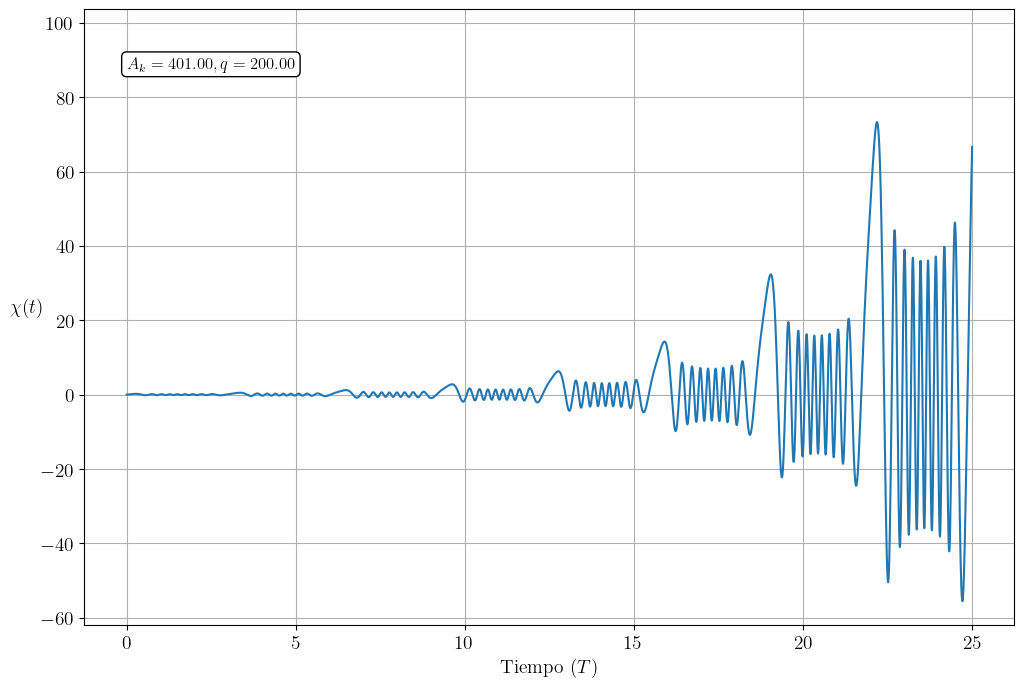

In [12]:
# Centrémosnos sólo en el que tiene A_k = 401 y q = 200
u0, v0 = 0, 1                                           # Condiciones iniciales
T0, Tf = 0, 25                                         # Tiempos
q = 200                             
Ak = 401

sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
T, y, y_prime = sol.t, sol.y[0], sol.y[1]

# Graficamos los resultados
plt.figure(figsize=(12, 8))
plt.plot(T, y)
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax*1.3)
plt.text(x=T[0], y=ymax*1.1, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()
plt.show()

## Número de partículas

El número de partículas del campo hijo estará dado por

$$n_\chi (k) = \frac{1}{2 \Omega_\chi} \left( \left| \frac{d \chi_k}{dT} \right|^2 + \Omega^2_\chi \left| \chi_k \right|^2 \right) - \frac{1}{2} \tag{10}$$

dónde

$$\Omega_\chi^2 (k, t) = \frac{k^2}{a^2} + g^2 \phi^2 (t) \tag{11}$$

Para el campo del inflatón recordemos que planteamos un potencial armónico entonces tenemos

$$\phi = \phi_0 \sin \left( T \right) \tag{12}$$

In [13]:
u0, v0 = 0, 1                                                                           # Condiciones iniciales
phi_0 = 1                                                                               # Amplitud del inflatón
a = 1                                                                                   # Factor de escala
g = 1e-4                                                                               # Constante de acoplamiento del inflatón

### Narrow resonance

Elijamos $q = 0.1$ y $A_k = 1.03$ de los cuadros de arriba y busquemos cómo es el número de partículas

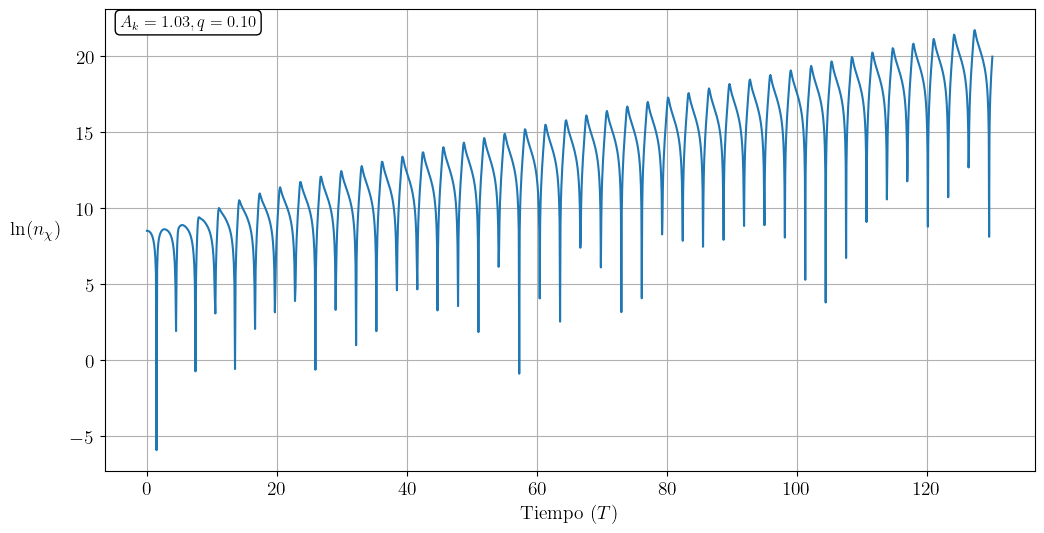

In [14]:
T0, Tf = 0, 130                                                                         # Tiempos
q = 0.1; Ak = 1.03
m = g/2 * phi_0 * np.sqrt(q)                                                            # Masa del campo hijo
k = np.sqrt(Ak - 2 * q) * m

sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
T, y, y_prime = sol.t, sol.y[0], sol.y[1]

phi = phi_0 * np.cos(T)                                                                 # Potencial armónico del inflatón
Omega_chi = np.sqrt((k**2 / a**2) + (g**2 * phi**2))                                             # Frecuencia del campo hijo

n = 1 / (2 * Omega_chi) * (np.abs(y_prime)**2 + Omega_chi**2 * np.abs(y)**2) - 1/2      # Número de partículas del campo hijo

# Graficamos los resultados
plt.plot(T, np.log(np.abs(n)))
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\ln (n_\chi)$', labelpad=25, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
xmin, xmax = plt.gca().get_xlim()
plt.yscale('linear')
plt.text(x=1.4*xmin+5, y=ymax*0.95, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()

plt.show()

### Broad resonance

Elijamos $q = 200$ y $A_k = 401$ de los cuadros de arriba

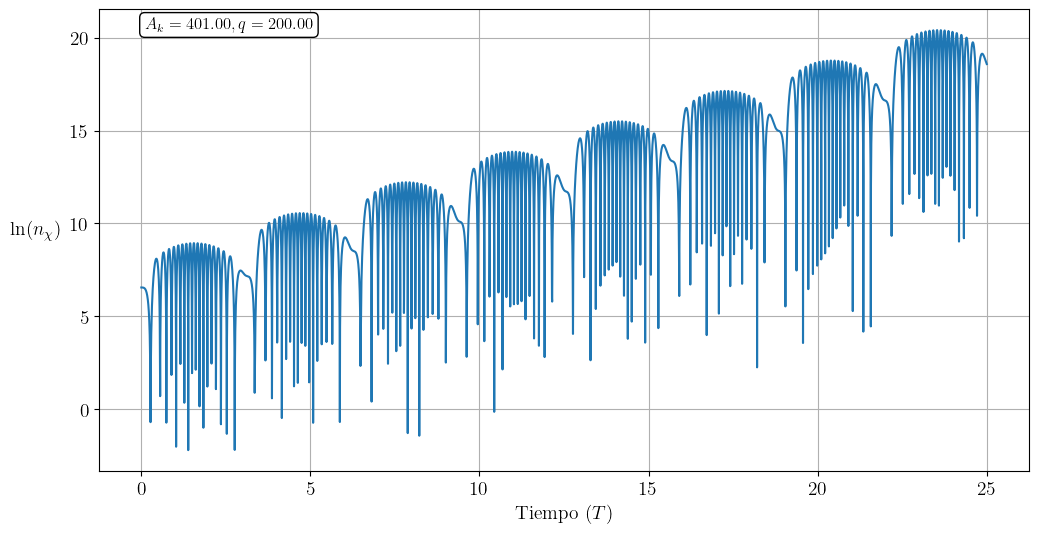

In [15]:
T0, Tf = 0, 25                                                                          # Tiempos
q = 200; Ak = 401
m = g/2 * phi_0 * np.sqrt(q)                                                            # Masa del campo hijo
k = np.sqrt(Ak - 2 * q) * m

sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
T, y, y_prime = sol.t, sol.y[0], sol.y[1]

phi = phi_0 * np.cos(T)                                                                 # Potencial armónico del inflatón
Omega_chi = np.sqrt((k**2 / a**2) + (g**2 * phi**2))                                    # Frecuencia del campo hijo

n = 1 / (2 * Omega_chi) * (np.abs(y_prime)**2 + Omega_chi**2 * np.abs(y)**2) - 1/2      # Número de partículas del campo hijo

# Graficamos los resultados
plt.plot(T, np.log(np.abs(n)))
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\ln (n_\chi)$', labelpad=25, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
xmin, xmax = plt.gca().get_xlim()
plt.yscale('linear')
plt.text(x=0.1, y=ymax*0.95, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()

plt.show()

## Dado un potencial arbitrario $V (\phi)$, ¿cómo es la dinámica de los campos $\phi$ y $\chi$?

Si tengo un potencial arbitrario de $\phi$, para obtener la dinámica de los campos debo resolver el siguiente sistema de ecuaciones:

$$\begin{align}
    \displaystyle \ddot{\chi}_k + \left[ k^2 + g^2 \phi^2 (t) \right] \chi_k &= 0\\
    \displaystyle \ddot{\phi} + \frac{\partial V}{\partial \phi} &= 0
\end{align} \tag{13}$$

### Funciones

In [16]:
# Definimos el potencial, su derivada y su segunda derivada
def potential(phi, l):
    V = (1/4) * l * phi**4
    dV = l * phi**3
    d2V = 3 * l * phi**2
    return V, dV, d2V

# Definimos las ecuaciones diferenciales
def dynamics(t, y, k, g, l):
    phi, phi_punto, chi, chi_punto = y
    
    # Ecuación para phi
    V, dV, d2V = potential(phi, l)
    phi_2punto = -dV
    
    # Ecuación para chi
    chi_2punto = -(k**2 + g**2 * phi**2) * chi
    
    return [phi_punto, phi_2punto, chi_punto, chi_2punto]

### Control

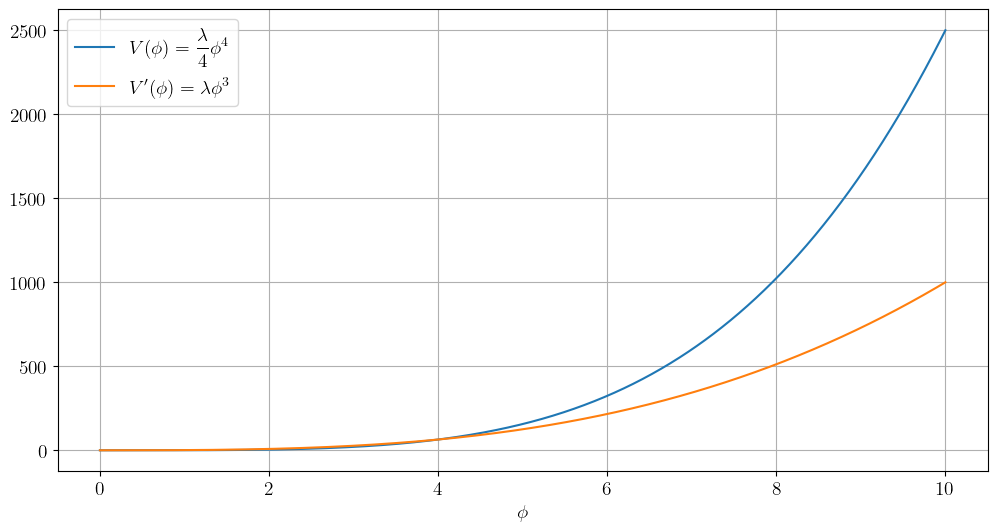

In [17]:
# Grafiquemos el potencial y su derivada para ver que son los que queremos

phi = np.linspace(0, 10, 1000)
l = 1
V, dV, d2V = potential(phi, l)

plt.plot(phi, V, label=r'$\displaystyle V(\phi) = \frac{\lambda}{4} \phi^4$')
plt.plot(phi, dV, label=r'$\displaystyle V^\prime(\phi) = \lambda \phi^3$')
plt.xlabel(r'$\phi$', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Dinámica de los campos

In [18]:
# Parámetros físicos
k = 1.0
g = 1e-4
l = 1e-13

# Rango de tiempo de integración
t0, tf = 0, 20
t_eval = np.linspace(t0, tf, int(1e6))

# Condiciones iniciales
phi0 = 1; phi_punto0 = 0                    # CI para phi
chi0 = 0; chi_punto0 = 1                    # CI chi
y0 = [phi0, phi_punto0, chi0, chi_punto0]

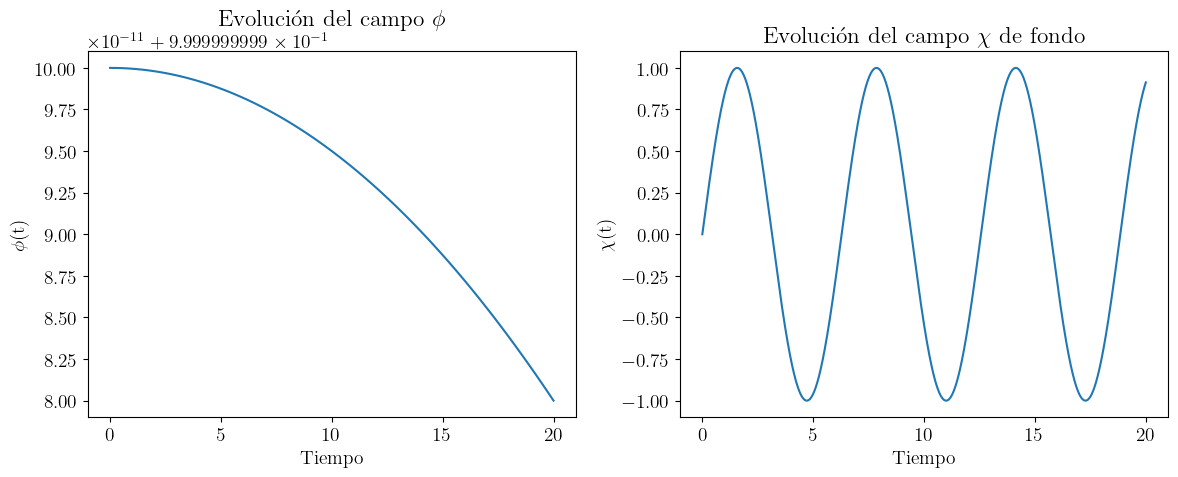

In [19]:
# Resolvemos el sistema acoplado
sol = solve_ivp(dynamics, [t0, tf], y0, args=(k, g, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)

# Extraemos los resultados
phi_sol = sol.y[0]
chi_sol = sol.y[2]

# Graficamos los resultados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sol.t, phi_sol)
plt.xlabel('Tiempo')
plt.ylabel(r'$\phi$(t)')
plt.title(r'Evolución del campo $\phi$')

plt.subplot(1, 2, 2)
plt.plot(sol.t, chi_sol)
plt.xlabel('Tiempo')
plt.ylabel(r'$\chi$(t)')
plt.title(r'Evolución del campo $\chi$ de fondo')

plt.tight_layout()
plt.show()

#### Variemos el valor de k para ver cómo es la dinámica de los campos para distintos modos

In [20]:
# Parámetros físicos
K = np.linspace(1e-2, 1, 21)
g = 1e-4
l = 1e-13

# Rango de tiempo de integración
t0, tf = 0, 100
t_eval = np.linspace(t0, tf, int(1e6))

# Condiciones iniciales
phi0 = 1; phi_punto0 = 0                    # CI para phi
chi0 = 0; chi_punto0 = 1                    # CI chi
y0 = [phi0, phi_punto0, chi0, chi_punto0]

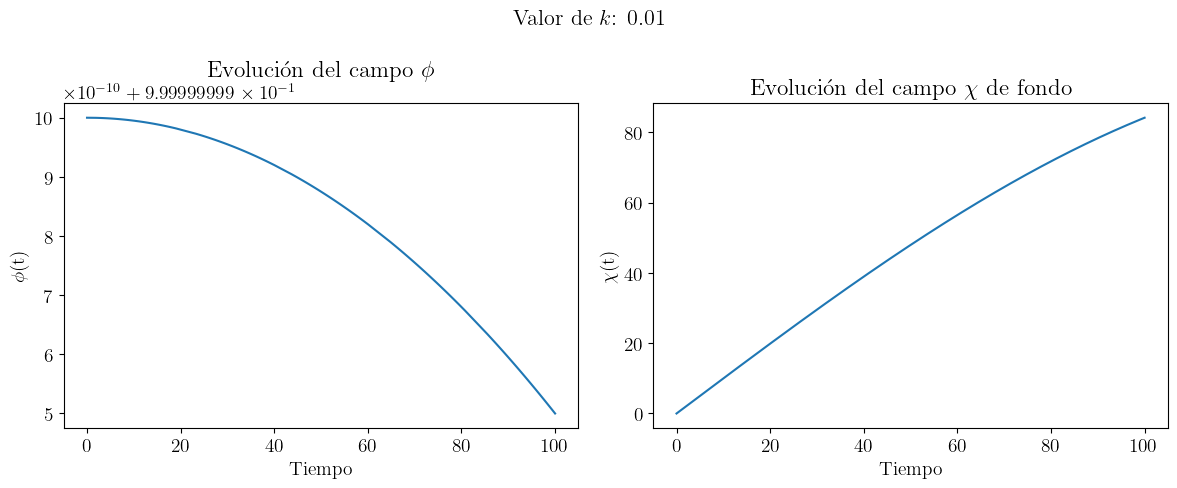

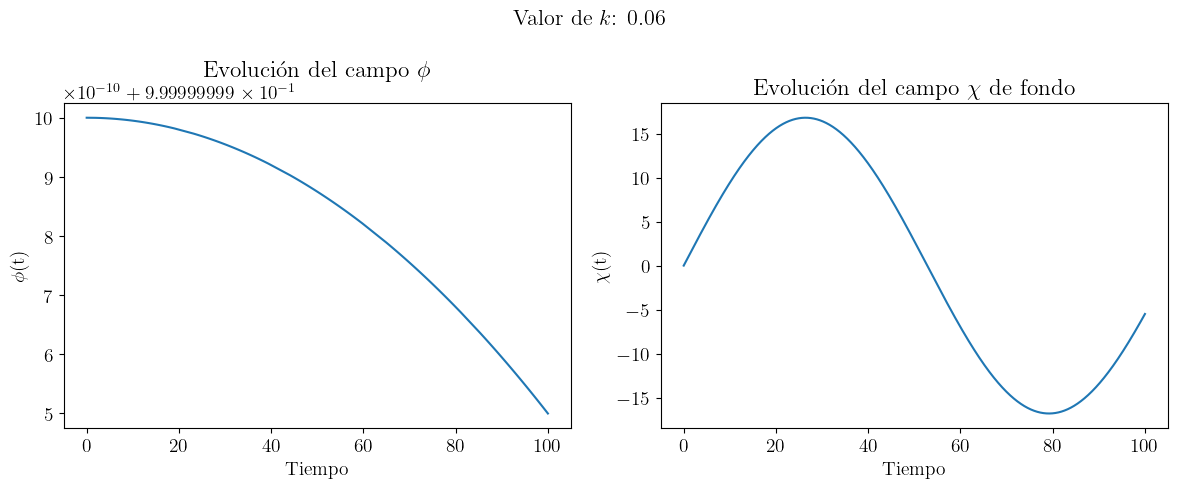

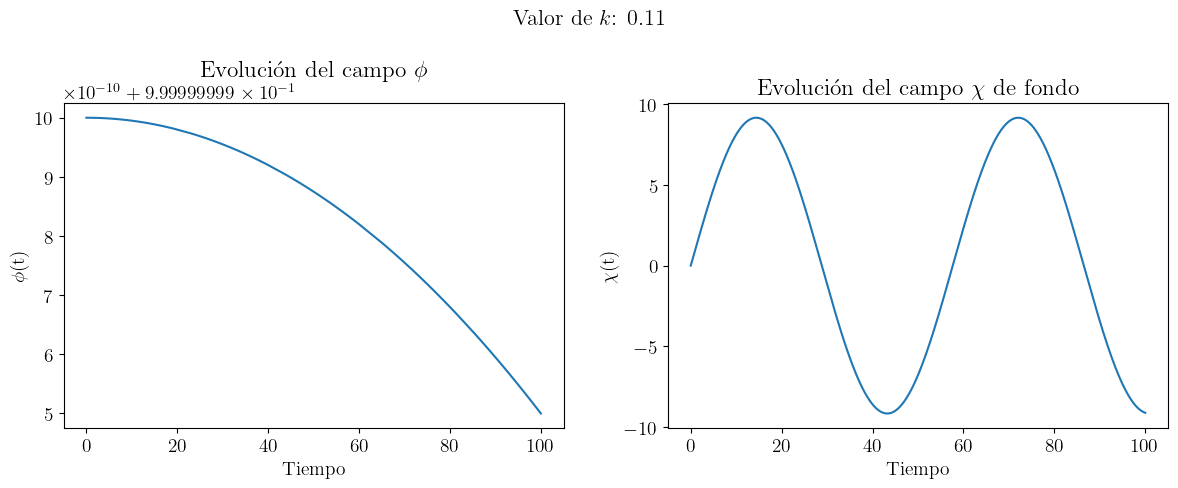

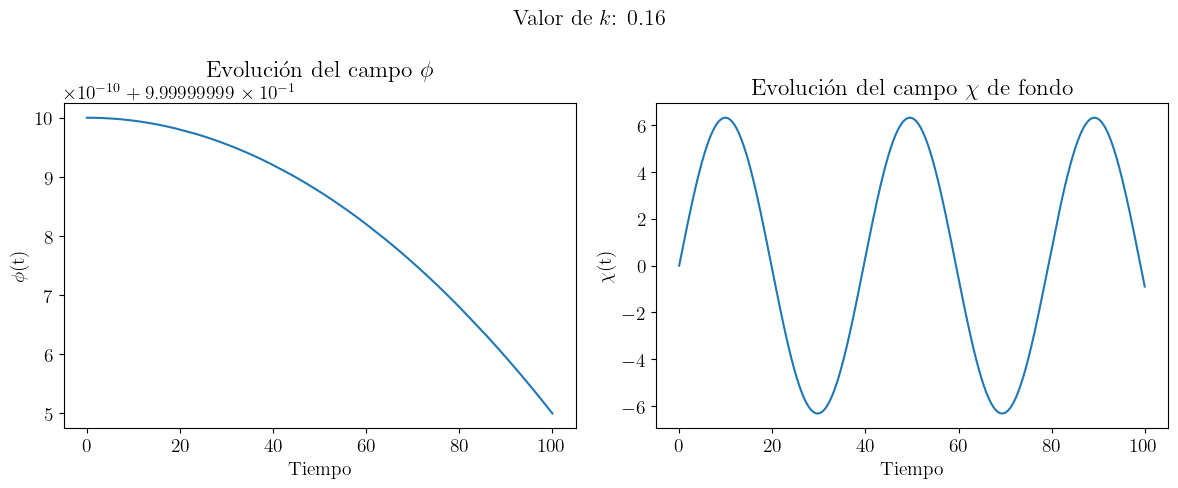

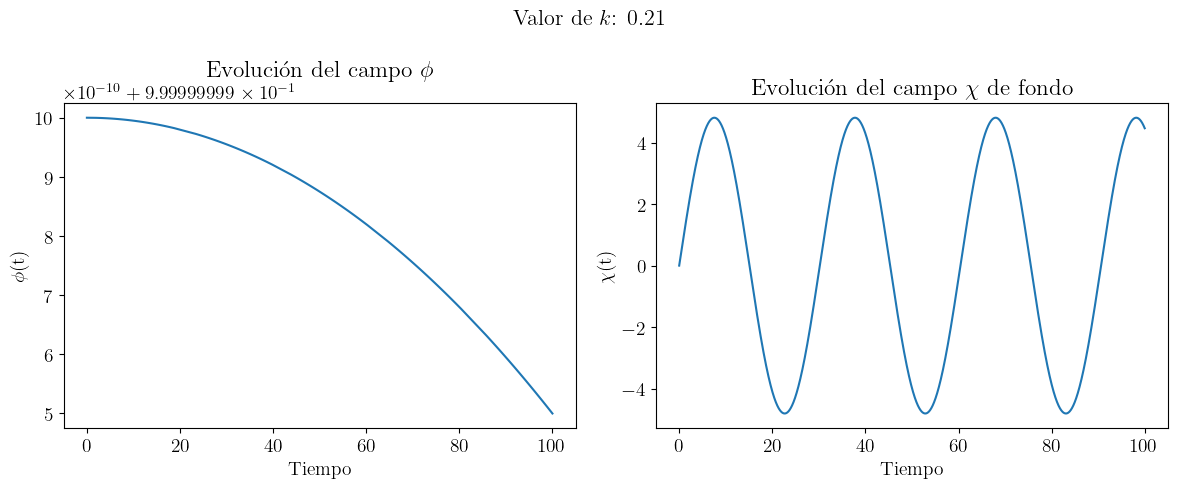

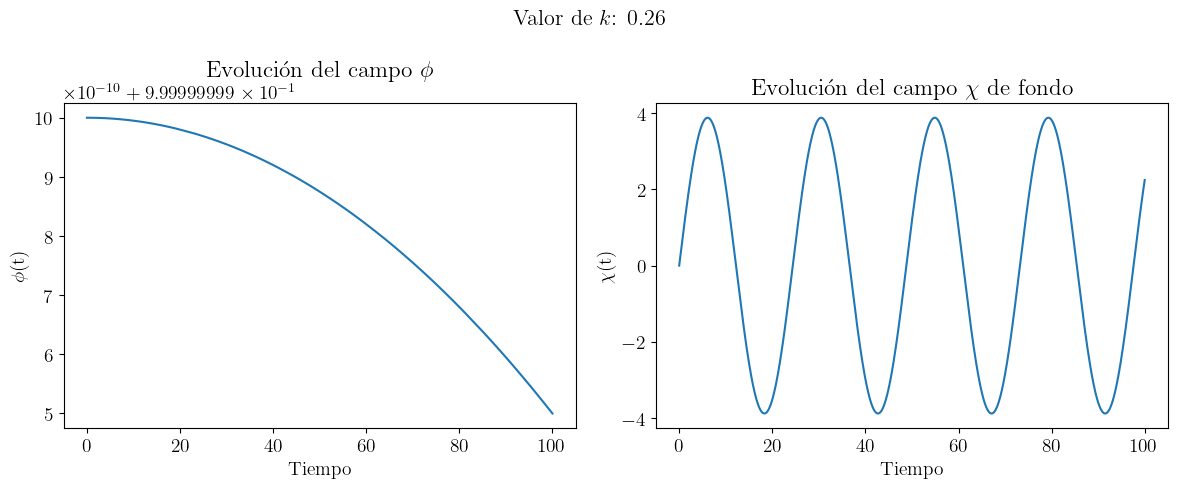

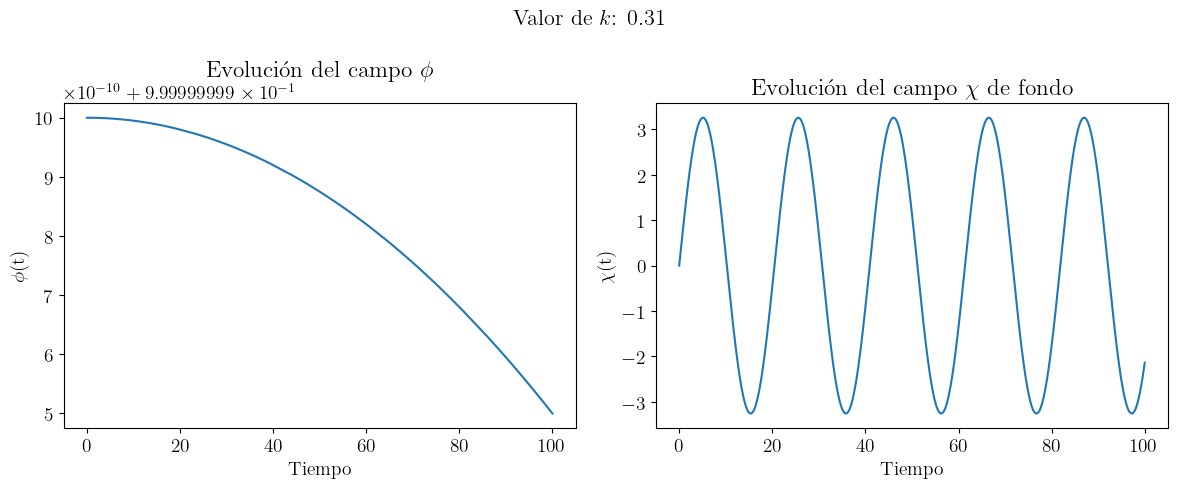

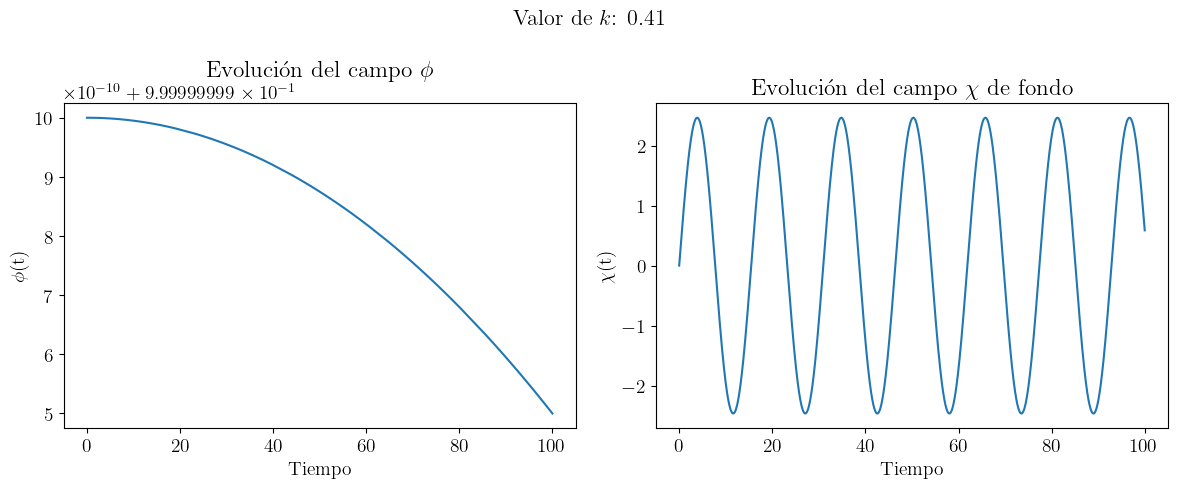

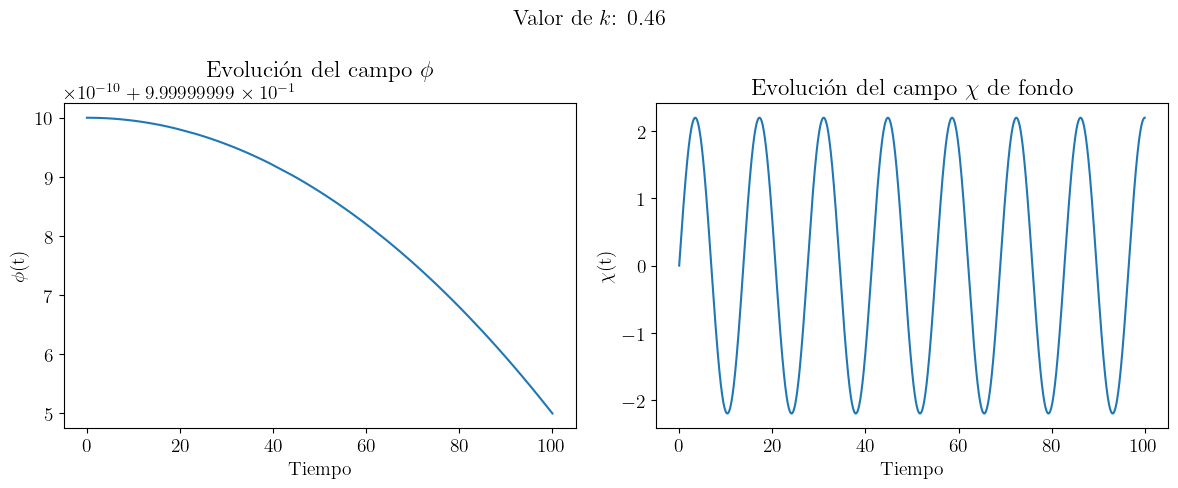

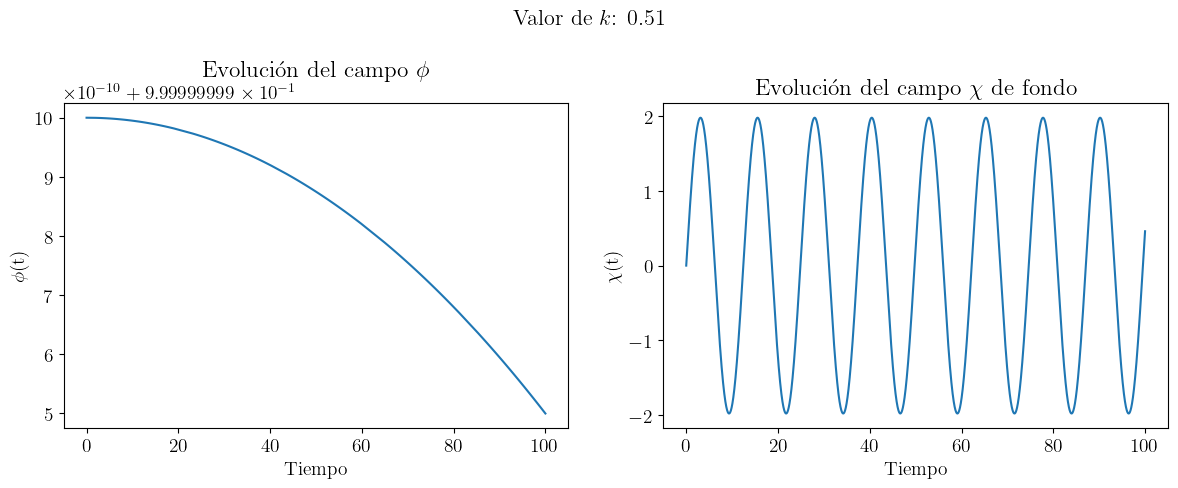

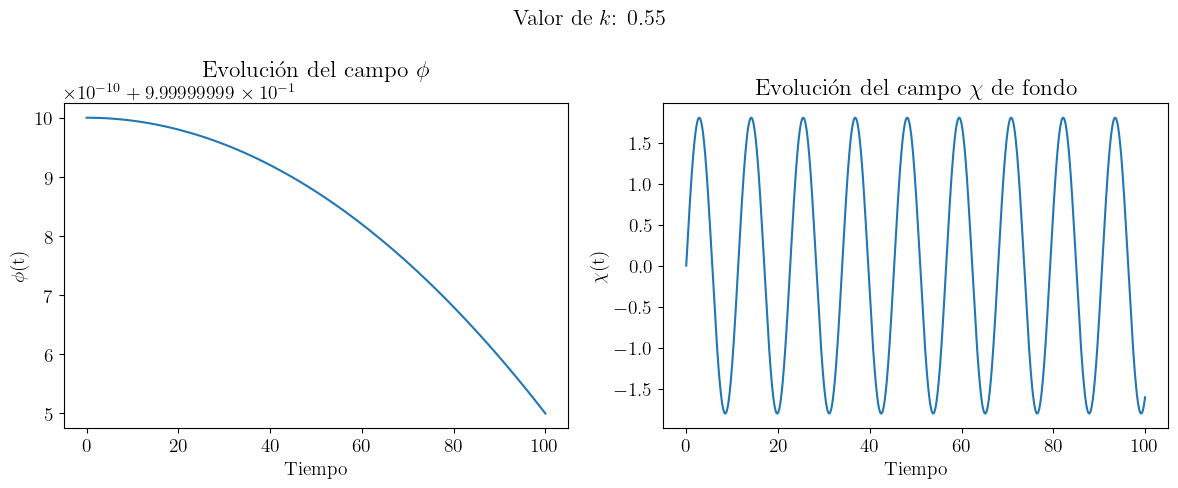

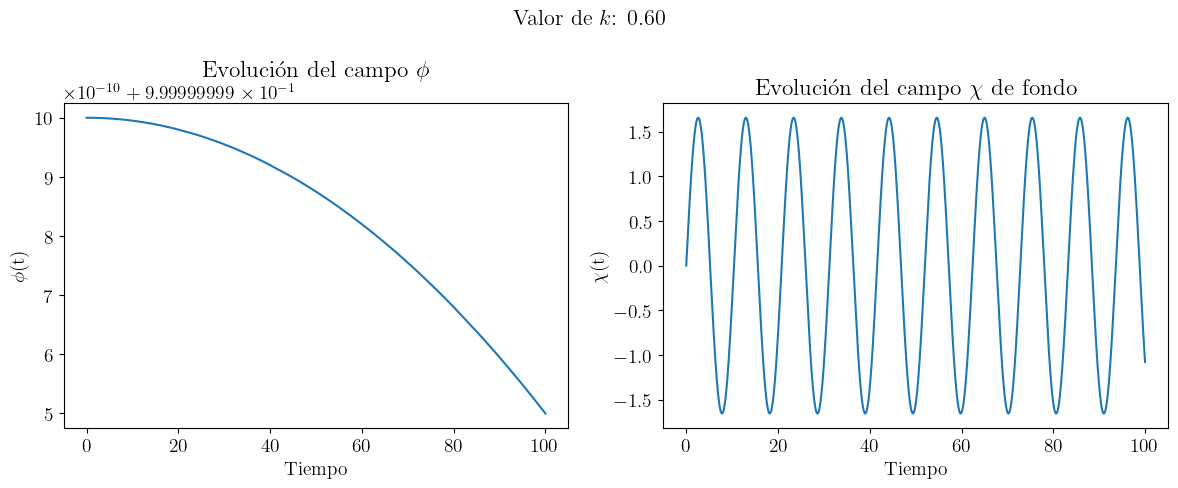

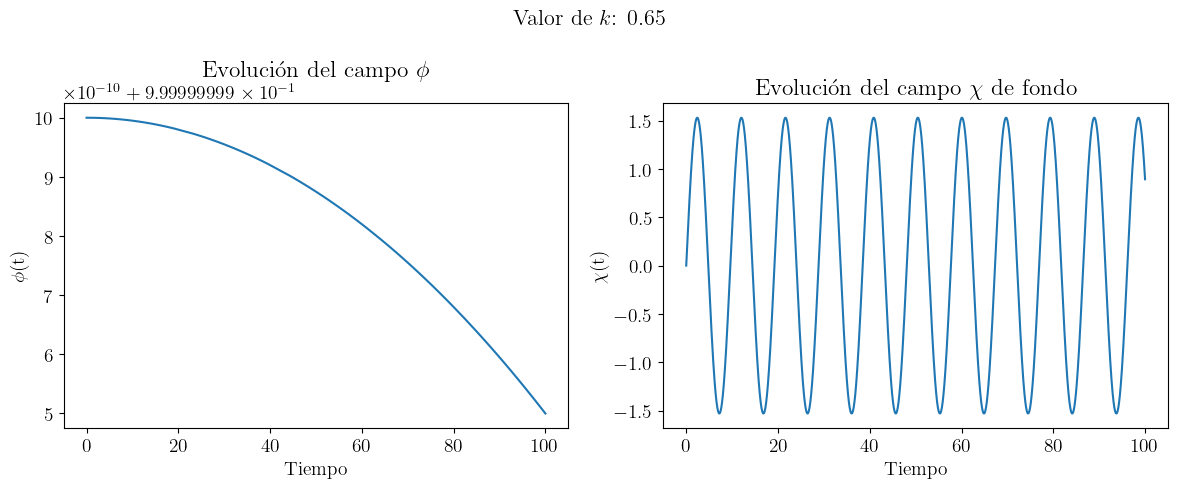

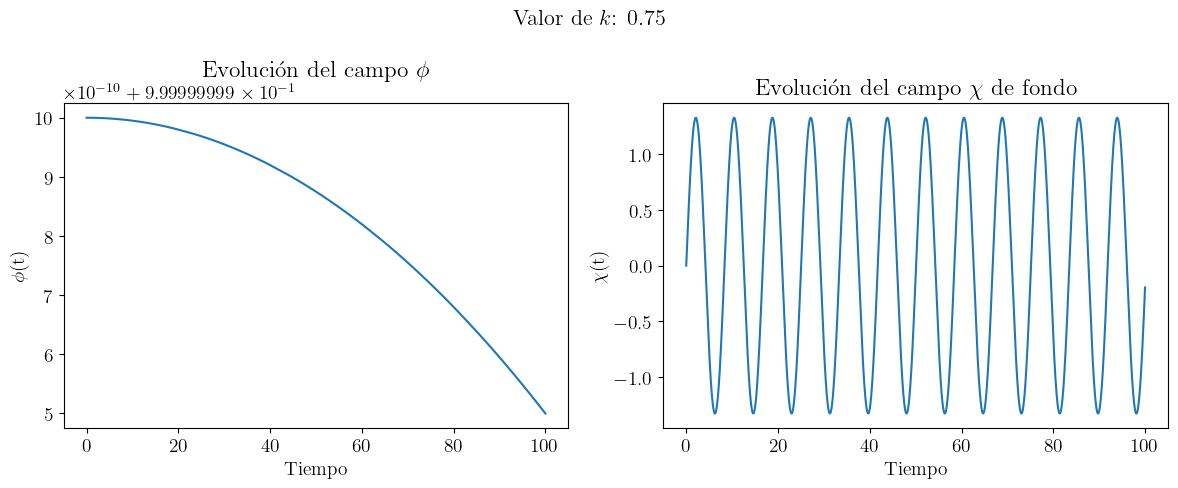

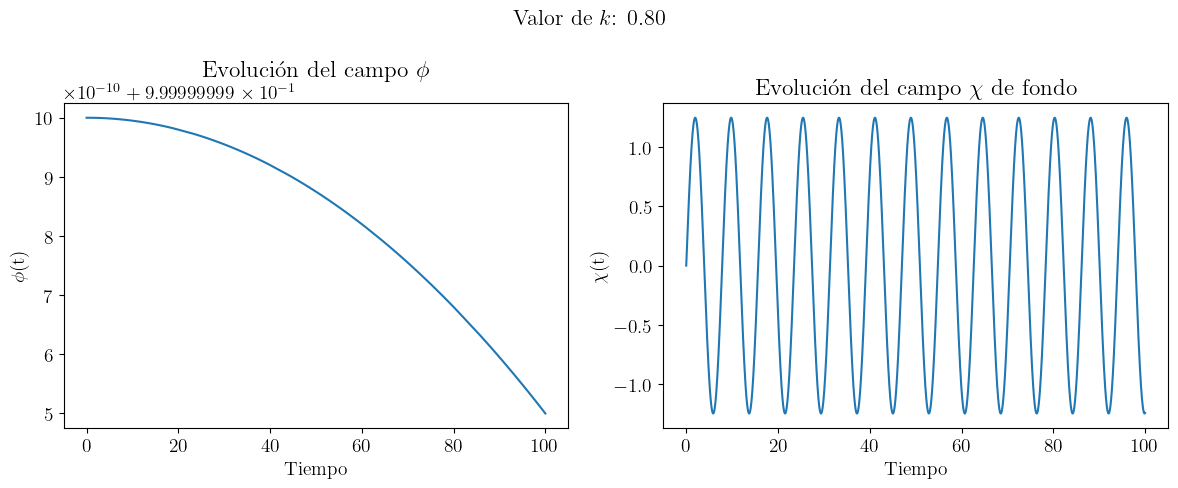

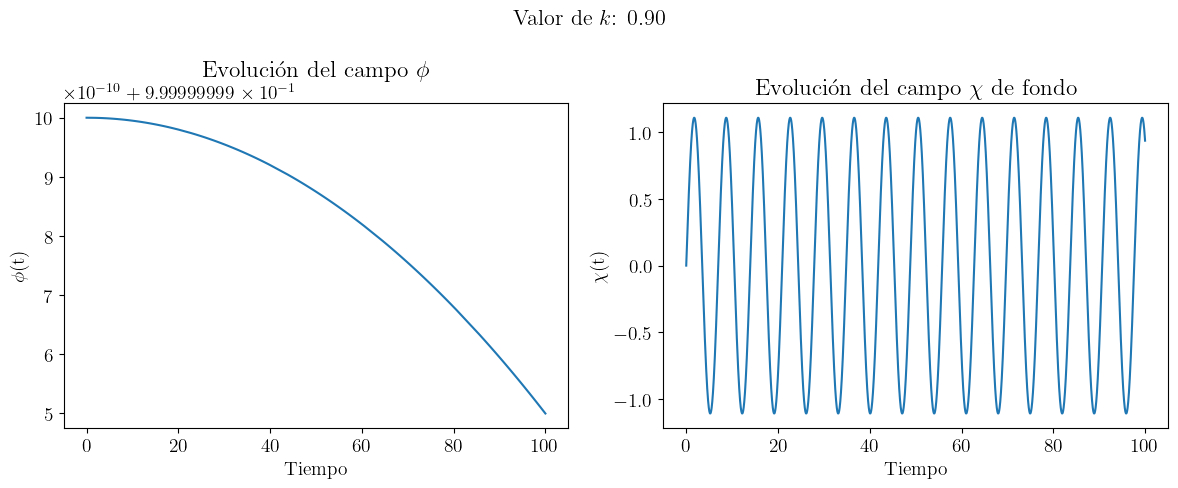

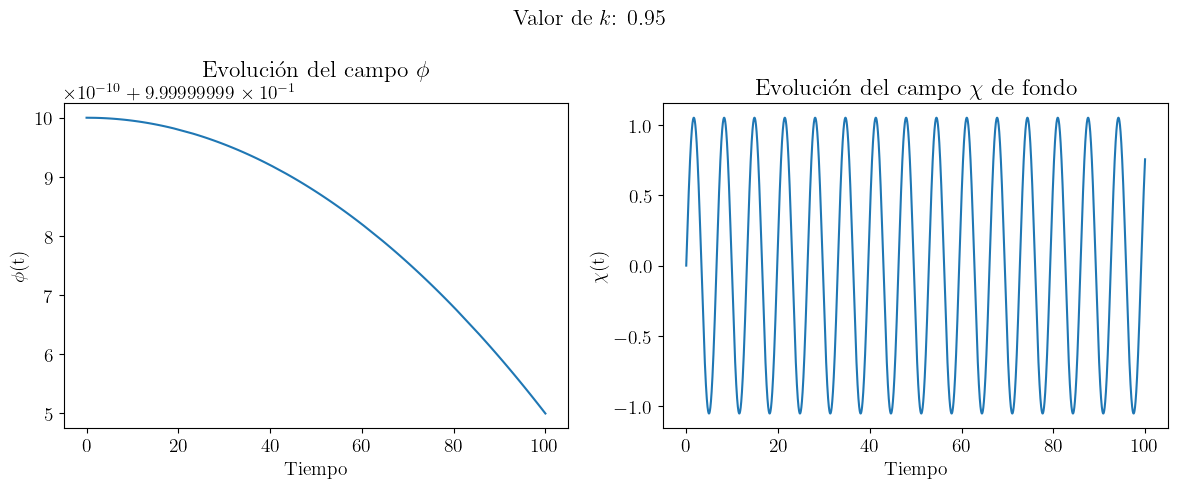

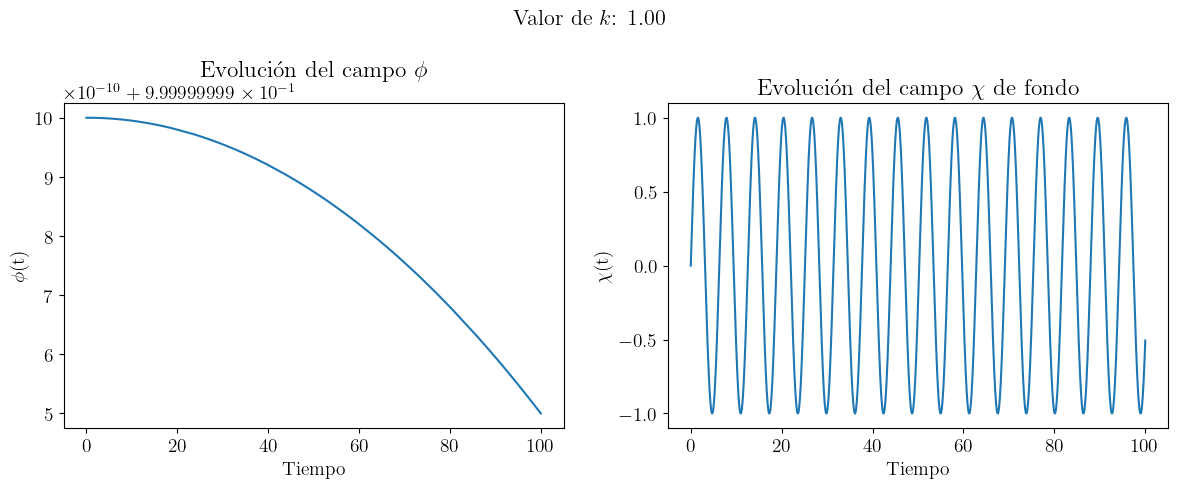

In [21]:
for k in K:
    # Resolvemos el sistema acoplado
    sol = solve_ivp(dynamics, [t0, tf], y0, args=(k, g, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)

    # Extraemos los resultados
    phi_sol = sol.y[0]
    chi_sol = sol.y[2]

    # Graficamos los resultados
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(sol.t, phi_sol)
    plt.xlabel('Tiempo')
    plt.ylabel(r'$\phi$(t)')
    plt.title(r'Evolución del campo $\phi$')
    
    plt.subplot(1, 2, 2)
    plt.plot(sol.t, chi_sol)
    plt.xlabel('Tiempo')
    plt.ylabel(r'$\chi$(t)')
    plt.title(r'Evolución del campo $\chi$ de fondo')
    plt.suptitle(r'Valor de $k$: ' + f'{k:.2f}', fontsize=16)
    plt.tight_layout()
    plt.show()

## Perturbaciones del inflatón ($\delta \phi$)

Las perturbaciones del inflatón cuando no tenemos expansión las podemos calcular a partir de 

$$\delta \ddot{\phi}_k +\left[ k^2 + V_{, \phi \phi} (\phi) \right] \delta \phi_k = 0 \tag{14}$$

### Funciones

In [22]:
# Definimos la ecuación de las perturbaciones del inflatón (\delta \phi)
def deltaphi(t, y, k, l):
    delta_phi, delta_phi_punto = y
    V, dV_dphi, d2V_dphi2 = potential(0, l)  
    delta_phi_2punto = -(k**2 + d2V_dphi2) * delta_phi
    
    return [delta_phi_punto, delta_phi_2punto]

### Dinámica de las perturbaciones

In [23]:
# Parámetros físicos
k = 1.0
l = 1e-13

# Rango de tiempo de integración
t0, tf = 0, 20
t_eval = np.linspace(t0, tf, int(1e6))

# Condiciones iniciales
deltaphi0 = 1; deltaphi_punto0 = 0      # CI para deltaphi
y0 = [deltaphi0, deltaphi_punto0]

In [24]:
# Resolvemos el sistema acoplado
sol = solve_ivp(deltaphi, [t0, tf], y0, args=(k, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)

# Graficamos los resultados
plt.figure(figsize=(12, 5))
plt.plot(sol.t, sol.y[0])
plt.xlabel('Tiempo')
plt.ylabel(r'$\delta \phi (t)$')
plt.title(r'Evolución de las perturbaciones lineales de $\phi$')
plt.show()

#### Veamos cómo son las perturbaciones para distintos modos $(k)$

In [25]:
# Parámetros físicos
K = np.linspace(1e-2, 1, 21)
l = 1e-13

# Rango de tiempo de integración
t0, tf = 0, 20
t_eval = np.linspace(t0, tf, int(1e6))

# Condiciones iniciales
deltaphi0 = 1; deltaphi_punto0 = 0      # CI para deltaphi
y0 = [deltaphi0, deltaphi_punto0]

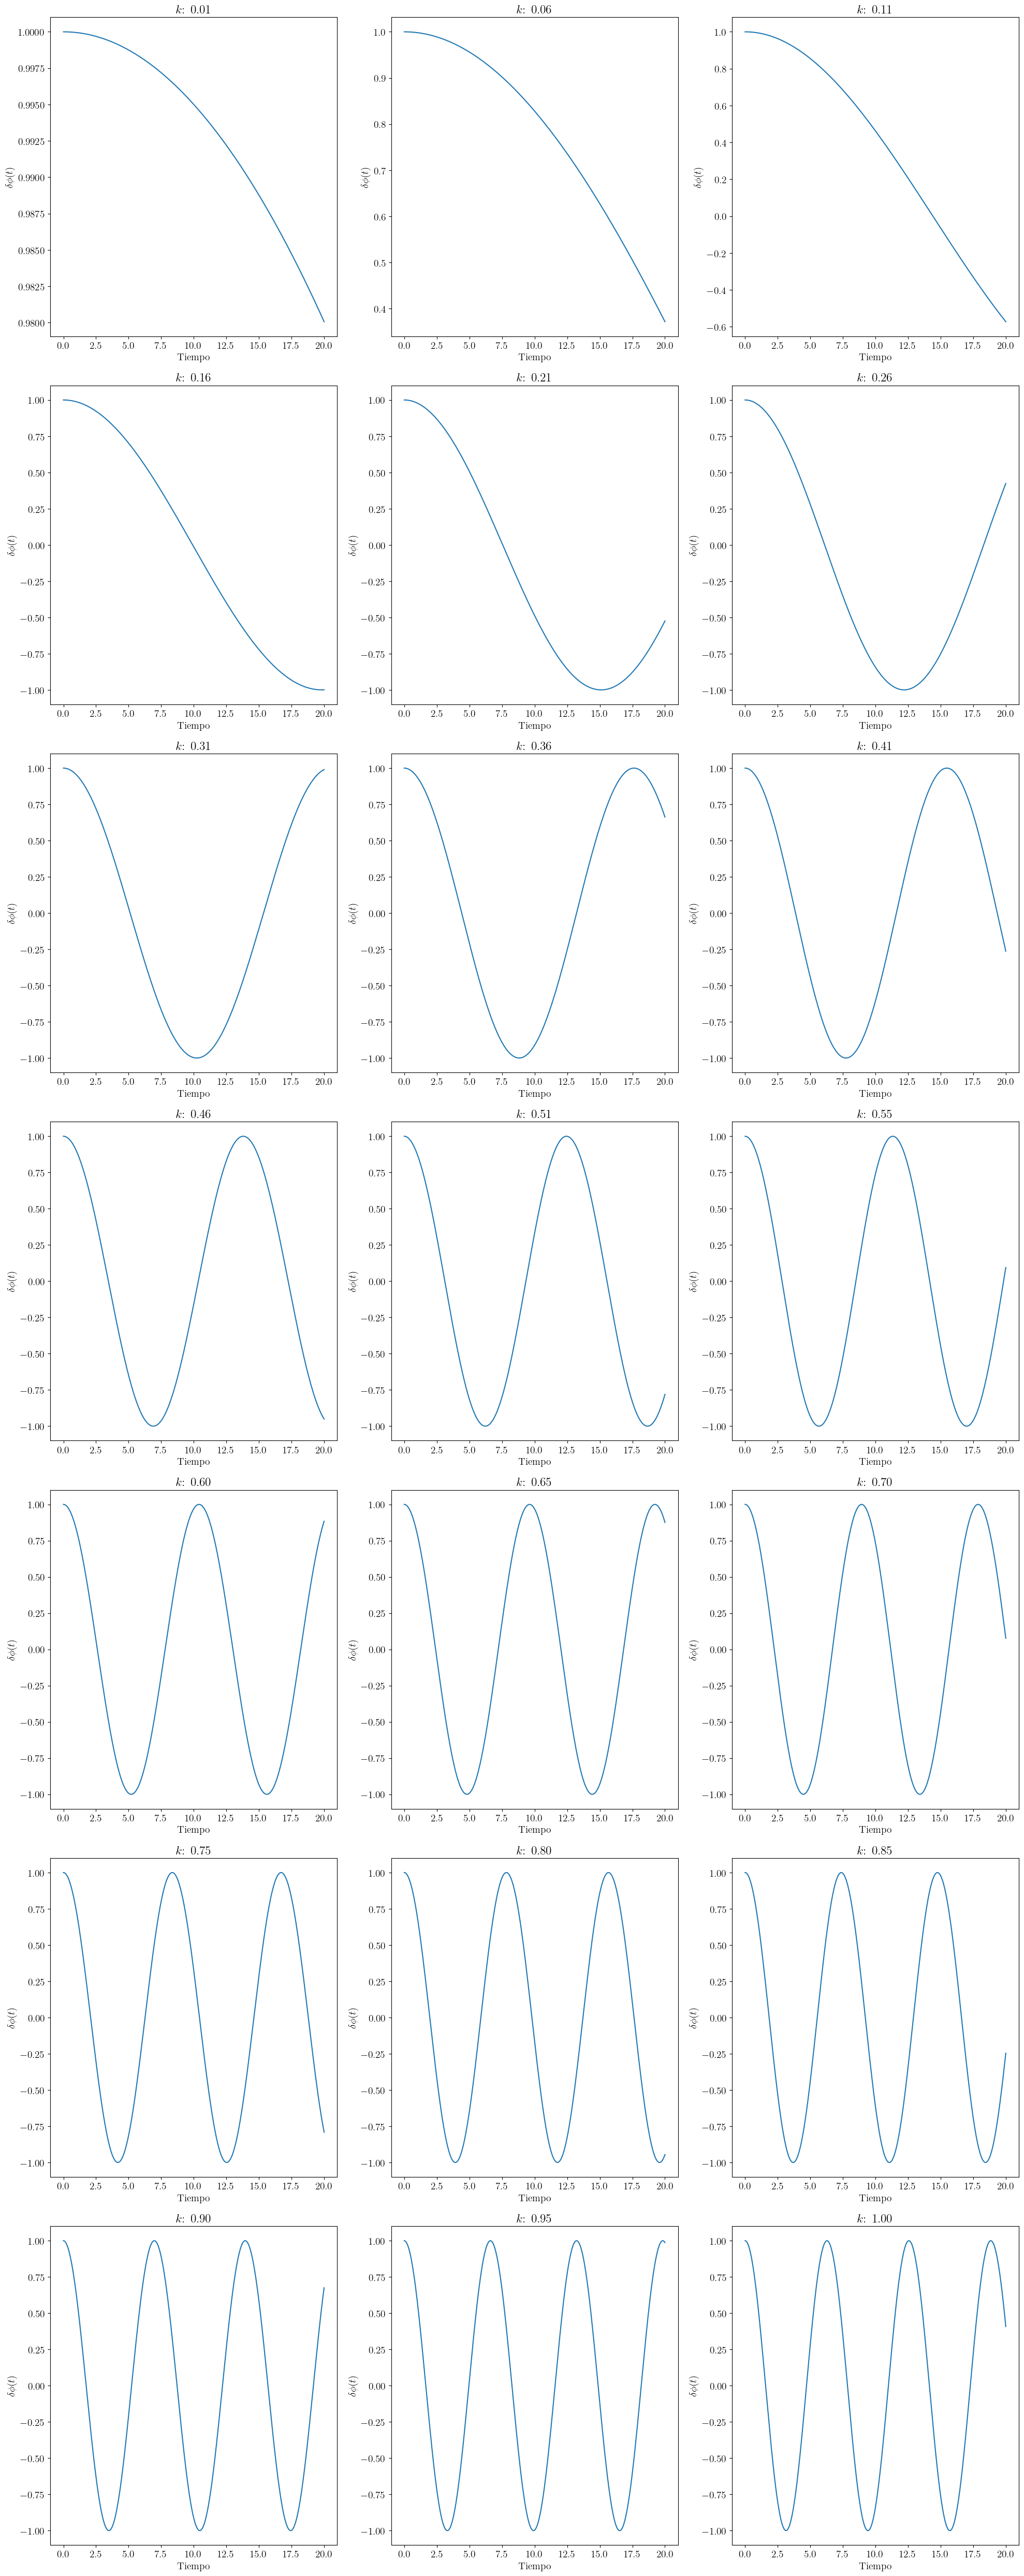

In [26]:
plt.figure(figsize=(20, 50))

for k in K:
    # Resolvemos el sistema acoplado
    sol = solve_ivp(deltaphi, [t0, tf], y0, args=(k, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)

    # Graficamos los resultados
    plt.subplot(7, 3, list(K).index(k) + 1)
    plt.plot(sol.t, sol.y[0])
    plt.xlabel('Tiempo')
    plt.ylabel(r'$\delta \phi (t)$')
    plt.title(r'$k$: ' + f'{k:.2f}')

plt.tight_layout()
plt.show()

#### Veamos la dinámica del campo inflatón completo (background + perturbaciones)

In [27]:
"""Veamos para un modo particular k"""

# Parámetros físicos
k = 1.0
g = 1e-4
l = 1e-13

# Rango de tiempo de integración
t0, tf = 0, 20
t_eval = np.linspace(t0, tf, int(1e6))

# Condiciones iniciales
phi0 = 1; phi_punto0 = 0                    # CI para phi
chi0 = 0; chi_punto0 = 1                    # CI chi
y0 = [phi0, phi_punto0, chi0, chi_punto0]

deltaphi0 = 1; deltaphi_punto0 = 0          # CI para deltaphi
deltay0 = [deltaphi0, deltaphi_punto0]

# Resolvemos el sistema acoplado
sol_delta = solve_ivp(deltaphi, [t0, tf], deltay0, args=(k, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)
sol_dyn = solve_ivp(dynamics, [t0, tf], y0, args=(k, g, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)

phi_background = sol_dyn.y[0]
dphi = sol_delta.y[0]
phi = phi_background + dphi

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(sol_dyn.t, phi)
plt.xlabel('Tiempo')
plt.ylabel(r'$\phi$(t)')
plt.title(rf'Evolución total del campo inflatón a primer orden para $k={k}$')
plt.grid(alpha = 0.3)
plt.show()

In [29]:
"""Variemos el modo y veamos cómo cambia la evolución total del campo inflatón a primer orden"""

# Parámetros físicos
K = np.linspace(1e-2, 1, 21)
g = 1e-4
l = 1e-13

# Rango de tiempo de integración
t0, tf = 0, 20
t_eval = np.linspace(t0, tf, int(1e6))

# Condiciones iniciales
phi0 = 1; phi_punto0 = 0                    # CI para phi
chi0 = 0; chi_punto0 = 1                    # CI chi
y0 = [phi0, phi_punto0, chi0, chi_punto0]

deltaphi0 = 1; deltaphi_punto0 = 0          # CI para deltaphi
deltay0 = [deltaphi0, deltaphi_punto0]

In [30]:
plt.figure(figsize=(20, 60))

for k in K:
    sol_delta = solve_ivp(deltaphi, [t0, tf], deltay0, args=(k, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)
    sol_dyn = solve_ivp(dynamics, [t0, tf], y0, args=(k, g, l), t_eval=t_eval, rtol=1e-8, atol=1e-8)

    phi_background = sol_dyn.y[0]
    dphi = sol_delta.y[0]
    phi = phi_background + dphi

    plt.subplot(7, 3, list(K).index(k) + 1)
    plt.plot(sol_dyn.t, phi)
    plt.xlabel('Tiempo')
    plt.ylabel(r'$\phi$(t)')
    plt.title(rf'$k={k:.2f}$')
    plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

## Dinámica de los campos con expansión del universo

Las ecuaciones de la dinámica de los campos cuando tenemos expansión son:

$$ \ddot{\phi} + 3 H \dot{\phi} + V_{,\phi} (\phi) = 0 \tag{15}$$

$$\delta \ddot{\phi}_k + 3 H ~ \delta \dot{\phi}_k + \left[ \frac{k^2}{a^2} + V_{,\phi \phi} (\phi) \right] \delta \phi_k \tag{16}$$

$$\ddot{\chi}_k + 3 H \dot{\chi}_k + \left( \frac{k^2}{a^2} + g^2 \phi^2 \right) \chi_k = 0 \tag{17}$$

dónde además debemos agregar la ecuación de Friedmann para poder modelar la expansión del universo

$$H^2 = \frac{1}{3 m_p^2} \left[ \frac{1}{2} \dot{\phi}^2 + V (\phi) \right] \tag{18}$$

Utilizando la definición del parámetro de Friedmann  podemos escribir las ecuaciones en términos de los campos y del parámtero de escala $a(t)$ como

$$\ddot{\phi} + 3 \frac{\dot{a}}{a} \dot{\phi} + V_{,\phi} (\phi) = 0 \tag{19}$$

$$\delta \ddot{\phi}_k + 3 \frac{\dot{a}}{a} ~ \delta \dot{\phi}_k + \left[ \frac{k^2}{a^2} + V_{, \phi \phi} (\phi) \right] \delta \phi_k = 0 \tag{20}$$

$$\ddot{\chi}_k + 3 \frac{\dot{a}}{a} \dot{\chi}_k + \left( \frac{k^2}{a^2} + g^2 \phi^2 \right) \chi_k = 0 \tag{21}$$

$$\dot{a} - \frac{a}{\sqrt{3} m_p} \sqrt{\frac{1}{2} \dot{\phi}^2 + V(\phi)} = 0 \tag{22}$$